<a href="https://colab.research.google.com/github/HugoKD/ML/blob/main/Exercice_RolandBerger_CADET_Hugo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RB DS exercise

## Problem statement

Our client is a private dental clinic chain with a current network of 71 stores in France. The aim of this project is to understand what drives **center performance** and more precisely identify to what extent it is driven by **internal factors** such as quality of service or by **external factors** such as number of patients in the catchment area.

Therefore our team of consultants and data scientists has gathered **data on the clients' centers** and on the catchment areas surronding these centers. This data is available in the file attached *20231124_dental_center_data.xlsx*.

In order to solve this case please write your code in the cells below each question. Please feel free to add markdown cells to specify your reasoning and comment your code for easier understanding.

**Note: please make sure to use a version of Python > 3.9 and to import all the necessary packages in the cell right below**

In [ ]:
# import your packages here
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap


from scipy.stats import skew
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline


from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score,LeaveOneOut,GridSearchCV,ShuffleSplit,KFold
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,ExtraTreesRegressor

from sklearn.metrics import r2_score, mean_squared_error as MSE,make_scorer,silhouette_score, mean_absolute_error as MAE
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import PartialDependenceDisplay,partial_dependence

from sklearn.cluster import SpectralClustering

from pyproj import Transformer
import geopandas as gpd
from geopy.distance import geodesic
from shapely.geometry import Point
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [ ]:
# check your python version
!python -V

Python 3.10.12


## Question 1

Inspect the data in the *20231124_dental_center_data.xlsx* file and **perform a descriptive data analysis**. Sample questions could be:
- Are there missing values?
- Are there outliers or unexpected values?
- Which variables are correlated, to what extend?
- ...

**Note: do not hesitate to use data vizualisation to support your findings**

In [ ]:
data = pd.read_excel('20231124_dental_center_data 1.xlsx').drop('ID', axis = 1)
data.shape

(71, 18)

The first thing we notice is the limited size of our dataset, which contains only 71 entries. This small sample size may constrain our ability to build reliable predictive models, as more data generally enables better generalization and accuracy. However, in this case, our objective is less about achieving prediction accuracy and more about understanding the underlying mechanisms of center performance and identifying key operational insights. Thus, while this exploration can still provide valuable findings, we need to exercise caution in our interpretations.
<br>

Furthermore, the dataset includes 17 features, which is relatively high compared to the number of entries. This imbalance increases the risk of overfitting, as the model may fit noise rather than underlying patterns due to the limited data. Consequently, this beeing said, we fully understand the reason of our mission.
<br>



In [ ]:
# We rename columns for easier manipulation later on.

columns_mapping = {
    'Dentist FTE [#]': 'fte',
    'Margin rate [21; %]': 'r_margin',
    'Revenue [21; EUR m]': 'revenue',
    'Number of reviews on Google [#]': 'nbr_reviews',
    'Average Google rating': 'avg_rating',
    'Rent in the area [EUR/sqm]': 'rent',
    'Patients in the catchment area [#]': 'nbr_patients',
    'Share of patients in the catchment area over 65 [%]': 'patients_over_65',
    'Unemployment rate in the catchment area [%]': 'r_unemployment',
    'Median revenue in catchment area [EUR]': 'median_revenue',
    'Poverty rate in the catchment area [%]': 'r_poverty',
    'Patients\' yearly growth in the catchment area [%]': 'patients_yearly_growth',
    'Density of doctors in the catchment area [#/100k patients]': 'density_doctors',
    'Density of pharmacists in the catchment area [ #/100k patients]': 'density_pharmacists',
    'Density of dentists in the catchment area [#/100k]': 'density_dentists'
}

data = data.rename(columns=columns_mapping)

data.head()

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
0,48.804336,2.420931,2.4,0.18,7.0,190.0,3.552632,5731,58874.899010,-0.24,13.060859,23330.857143,7.8,13.615055,133.0,66,104,2019
1,49.895083,2.298487,2.6,0.21,9.0,153.0,4.039216,2708,39687.660222,0.18,13.514219,19647.037037,9.6,20.113324,173.0,33,121,2019
2,43.578549,7.119384,3.3,0.21,10.0,163.0,4.288344,4751,25370.677794,-0.68,33.162485,22524.666667,12.5,15.142544,177.0,69,112,2018
3,43.655764,1.370467,2.2,0.09,10.0,145.0,4.158621,3205,6945.136108,1.83,10.971403,23213.333333,8.1,8.124205,179.0,89,116,2020
4,44.879637,-0.570372,2.9,0.21,8.0,63.0,4.650794,3707,6992.074760,1.08,9.078928,19480.000000,7.4,30.930467,182.0,76,121,2019


In [ ]:
operational_features = ['revenue', 'r_margin' 'fte', 'nbr_reviews', 'avg_rating','nbr_patients','Opening year']
catchment_features = [
    'rent','patients_yearly_growth','patients_over_65','median_revenue',
    'r_unemployment','r_poverty','density_doctors','density_pharmacists','density_dentists'
]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Latitude                71 non-null     float64
 1   Longitude               71 non-null     float64
 2   revenue                 66 non-null     float64
 3   r_margin                66 non-null     float64
 4   fte                     66 non-null     float64
 5   nbr_reviews             68 non-null     float64
 6   avg_rating              68 non-null     float64
 7   rent                    71 non-null     int64  
 8   nbr_patients            70 non-null     float64
 9   patients_yearly_growth  71 non-null     float64
 10  patients_over_65        71 non-null     float64
 11  median_revenue          71 non-null     float64
 12  r_unemployment          70 non-null     float64
 13  r_poverty               70 non-null     float64
 14  density_doctors         69 non-null     floa

The data appears to be perfectly homogeneous, which is advantageous for our analysis since it suggests minimal additional cleaning will be required. However, this does not eliminate the need for some preprocessing steps to prepare the data for modeling.

#### Missing Values

In [ ]:
data.isna().sum()/len(data)*100 ## See the proportion of missing data for each feature

,0
Latitude,0.000000
Longitude,0.000000
revenue,7.042254
r_margin,7.042254
fte,7.042254
nbr_reviews,4.225352
avg_rating,4.225352
rent,0.000000
nbr_patients,1.408451
patients_yearly_growth,0.000000


Here, we observe a considerable number of missing values. We need to understand the reasons behind these gaps—whether they stem from a lack of information, represent a value of zero, or carry another specific meaning.

Our main strategy is as follows:


*   If the clinic opened in 2021, we can infer that the missing value is likely **null**.

*   If there is no clear pattern to infer missing values, and given that there aren’t too many, we can **look up their location online** to manually complete the information ourselves.

* Employ **imputation tool** if there is no publicly available information.




In [ ]:
data[data["fte"].isna()]

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
17,48.736834,1.365297,NaN,NaN,NaN,19.0,4.578947,1590,16206.342013,-0.46,15.763840,17016.923077,7.2,24.174403,106.0,40,104,2016
20,49.023062,1.148888,NaN,NaN,NaN,10.0,4.700000,1844,17408.129904,-1.24,19.890533,18980.000000,8.1,15.407340,96.0,34,109,2019
29,48.959236,2.882169,NaN,NaN,NaN,33.0,4.060606,2870,23423.885548,0.61,13.688214,19556.153846,7.4,13.890370,100.0,44,78,2016
34,48.692024,6.181425,NaN,NaN,NaN,14.0,4.714286,2559,52741.353401,0.16,13.566230,21786.206897,7.8,17.647573,176.0,73,120,2018
37,43.838278,4.363345,NaN,NaN,NaN,NaN,NaN,1988,55887.755483,-0.12,21.732715,18604.666667,11.0,25.542045,150.0,72,114,2021


We can see that all missing values for revenue, r_margin, and FTE are concentrated in **5 centers**. We can infer that if the clinic opened in the year the measurement was taken (2021), the missing values likely correspond to zero. For the remaining data, without additional information, we will apply an imputation method, which we will address later, as this kind of information is often private.

Furthermore we can see that there is some non coherent value for density doctors (negative).

In [ ]:
negative_values = (data < 0).sum()
print(negative_values) #valeur aberrante pour density

Latitude                   0
Longitude                  6
revenue                    0
r_margin                   4
fte                        0
nbr_reviews                0
avg_rating                 0
rent                       0
nbr_patients               0
patients_yearly_growth    34
patients_over_65           0
median_revenue             0
r_unemployment             0
r_poverty                  0
density_doctors            1
density_pharmacists        0
density_dentists           0
Opening year               0
dtype: int64


In [ ]:
data[data['density_doctors'] <0]

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
9,49.183878,-0.362323,2.2,0.09,6.0,199.0,4.316583,3459,27532.624233,-0.32,15.541685,22510.0,7.2,10.087484,-237.0,47,106,2020


In [ ]:
data[["density_doctors"]].describe()

,density_doctors
count,69.000000
mean,169.869565
std,67.395434
min,-237.000000
25%,150.000000
50%,174.000000
75%,186.000000
max,248.000000


We can infer that the person who entered this negative value in the database likely **intended it to be positive**, especially considering that the clinic is located in **Caen, France—a densely populated city** with 158 general practitioners for 108,000 inhabitants as of 2023. We allow ourselves to investigate this small detail, as in the case of a **small dataset, every data point is important.**

We did the same search for r_unemployment and r_poverty for the 2 entries where there was a NaN value by searching their localisation and comparing with there respective mean value.

In [ ]:
data[data['r_unemployment'].isna()]

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
30,43.773873,7.500619,1.6,0.09,6.0,90.0,4.7,5089,12573.245987,1.47,32.962261,21270.0,NaN,15.734146,199.0,71,130,2020


In [ ]:
data[data['r_poverty'].isna()]

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
14,45.779301,3.081492,0.0,0.1,2.0,7.0,4.714286,2469,55915.37181,0.73,17.044792,21461.785714,7.0,NaN,158.0,78,134,2018


In [ ]:
data[["r_unemployment"]].describe()

,r_unemployment
count,70.000000
mean,7.835714
std,1.659670
min,5.800000
25%,6.400000
50%,7.200000
75%,8.425000
max,12.500000


In [ ]:
data[["r_poverty"]].describe()

,r_poverty
count,70.000000
mean,16.752048
std,7.758953
min,2.370061
25%,11.987072
50%,15.454031
75%,19.536252
max,47.600799


By searching on the internet, we found that the poverty rate in **Clermont-Ferrand** (where the clinic in the 30th entry is located) is 25%, and that the poverty rate in **Menton** is among the highest in the dataset but **still consistent**, at 12%. Therefore, we will use these values to replace NaN values instead of using basic imputation.

Once again, we searched online to complete the missing information on the number of reviews and average rating, except for the clinic that opened in 2021 (as previously mentioned), since this information is readily accessible.

In [ ]:
data[data['nbr_reviews'].isna()]

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
28,43.303751,5.368211,0.0,0.01,5.0,NaN,NaN,3087,74590.427964,0.30,15.303172,14587.500000,9.4,43.919041,183.0,88,134,2017
37,43.838278,4.363345,NaN,NaN,NaN,NaN,NaN,1988,55887.755483,-0.12,21.732715,18604.666667,11.0,25.542045,150.0,72,114,2021
59,49.845012,3.290347,0.0,-0.05,0.0,NaN,NaN,1121,25053.139562,-0.67,19.469618,17883.809524,6.0,22.908162,110.0,42,94,2016


In [ ]:
data[["nbr_reviews"]].describe()

,nbr_reviews
count,68.000000
mean,132.029412
std,96.637339
min,4.000000
25%,47.000000
50%,119.500000
75%,190.500000
max,359.000000


In [ ]:
data[['avg_rating']].describe()

,avg_rating
count,68.000000
mean,4.137079
std,0.421768
min,3.331897
25%,3.852150
50%,4.126894
75%,4.469948
max,5.000000


We see that for the 28th entry, the number of reviews is 269 with an average rating of 4.7, and for the 59th entry, the number is 27 with an average rating of 3.7. Both are consistent values

#### Correlation and distribution

Now, we will analyze the feature distribution.

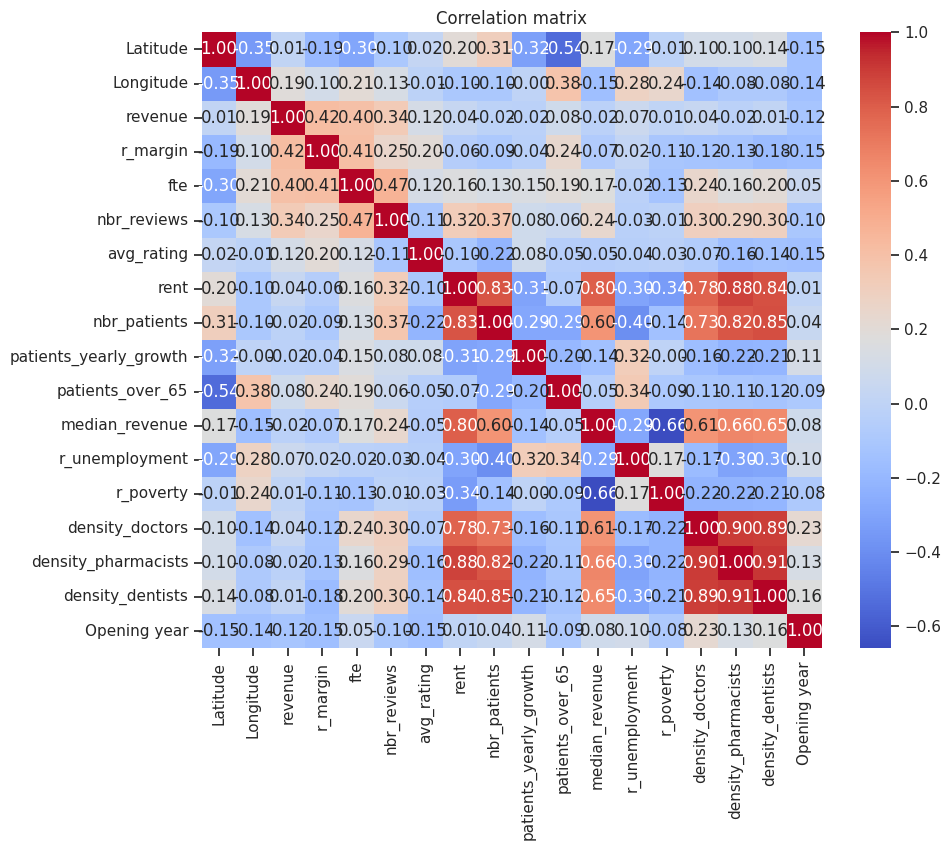

In [ ]:
plt.figure(figsize=(10, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

It is clear that densities are well corelated (>0.69), which is kind of obvious because of the meaning of those feature. Even if PCA is appealing, it is in my opinion a bad idea because of the nature of our task.

Even though we are not asked to make any predictions, it is often good practice to reduce data skewness and limit outliers, especially with small datasets. To analyze this, we use the popular Seaborn library, to then decide which transformation to use.

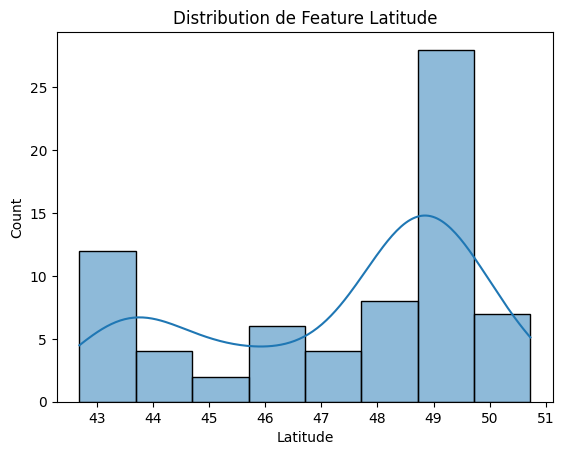

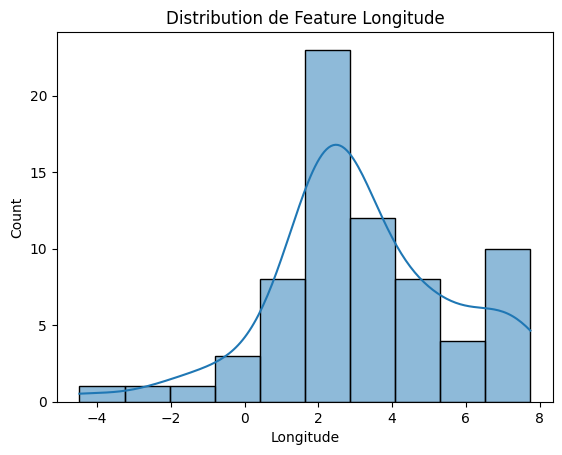

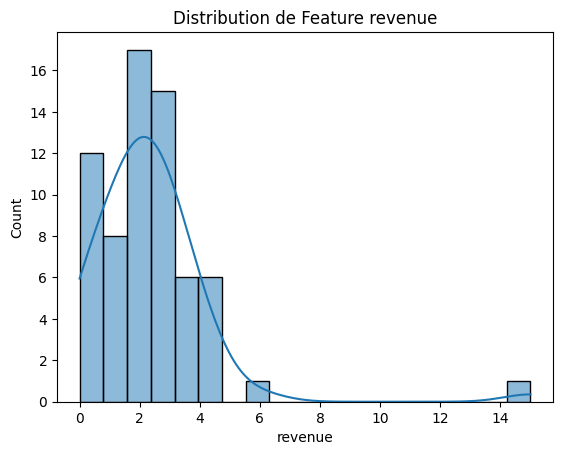

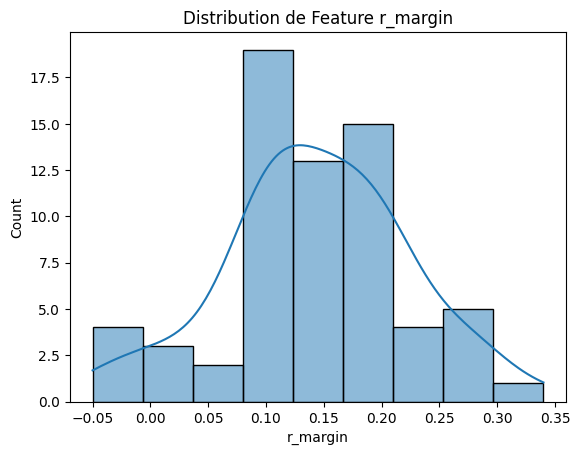

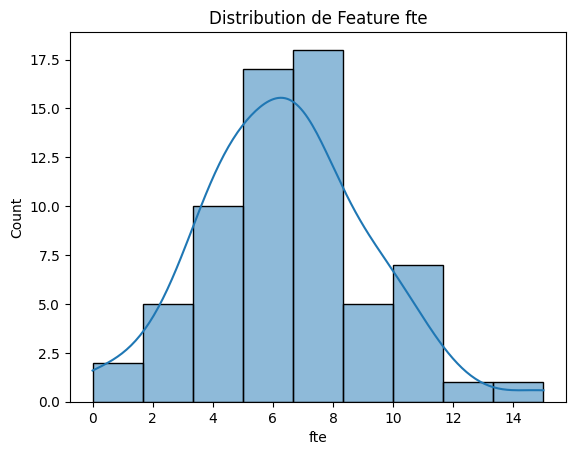

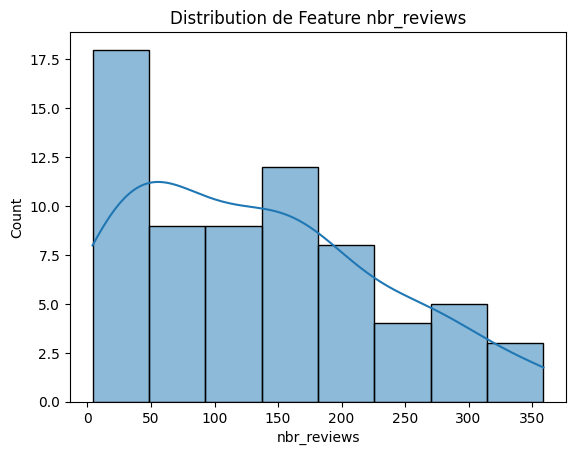

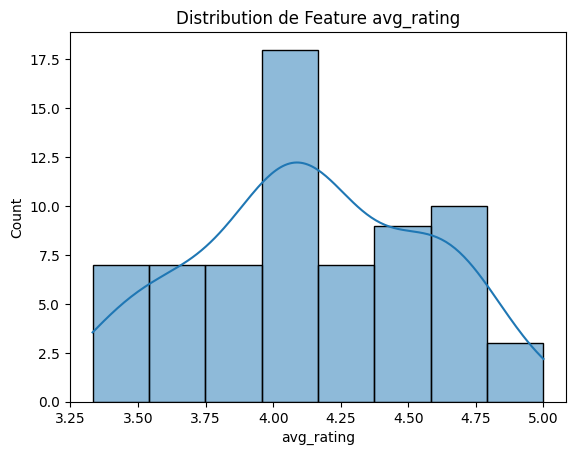

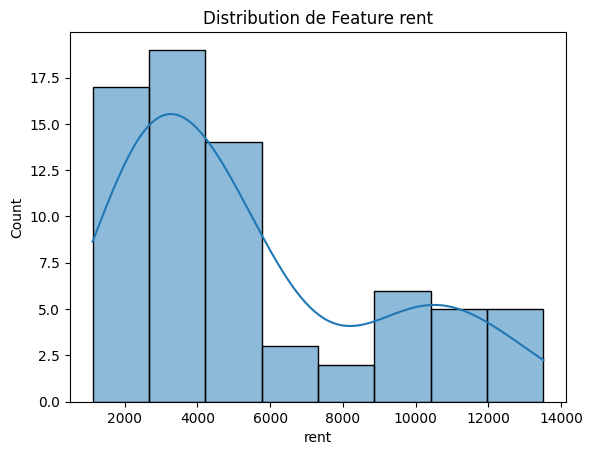

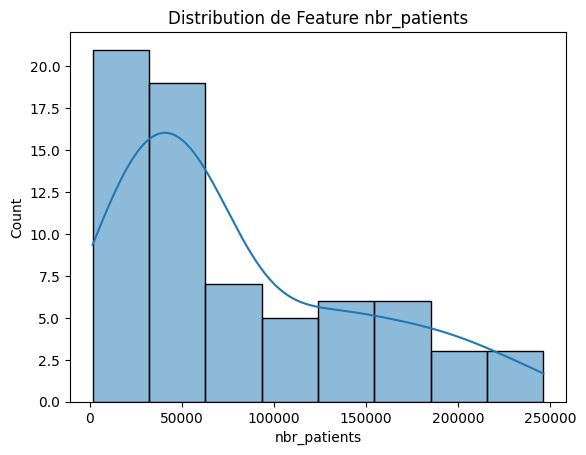

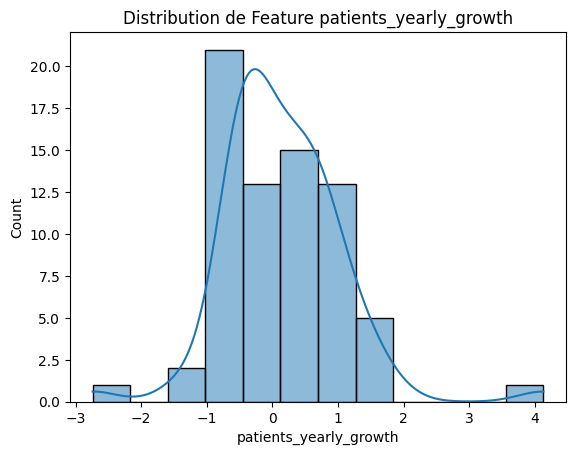

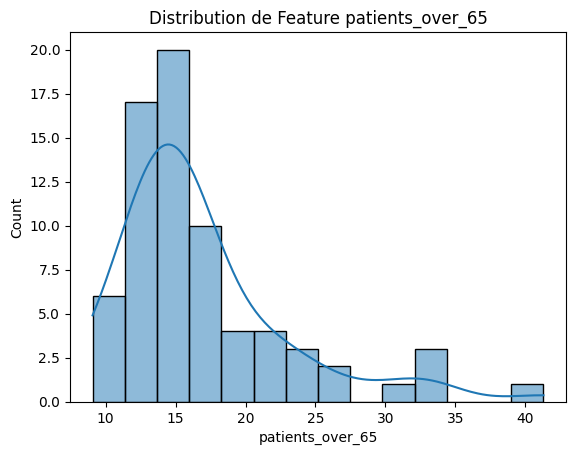

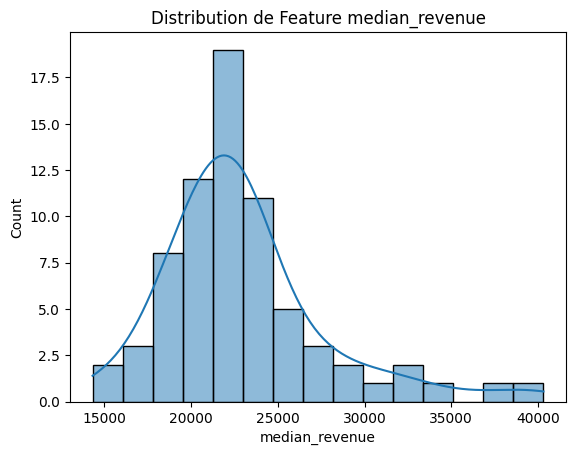

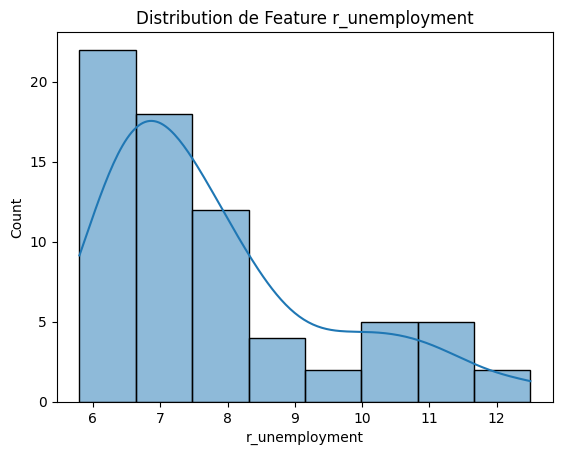

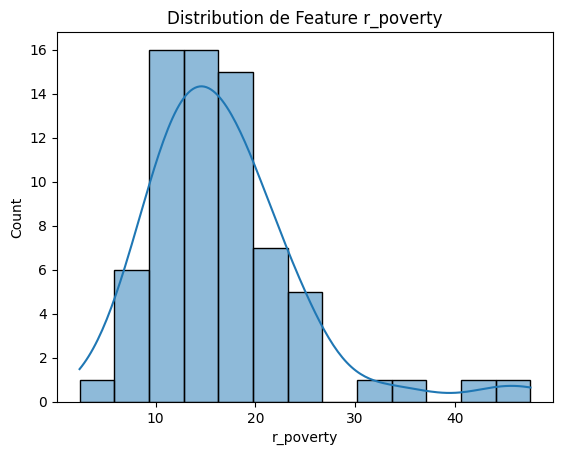

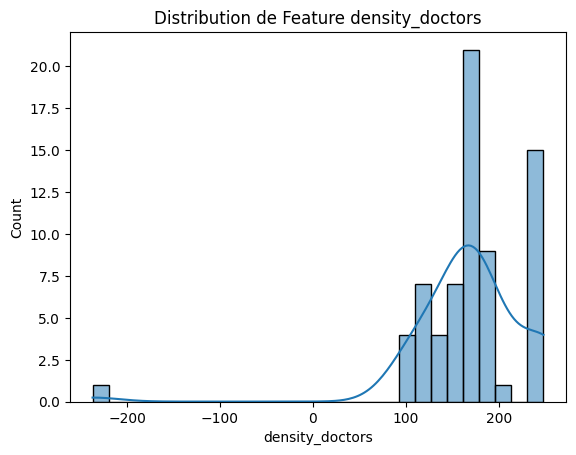

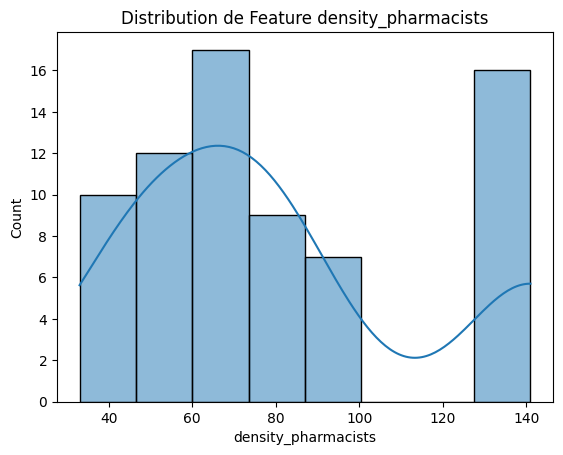

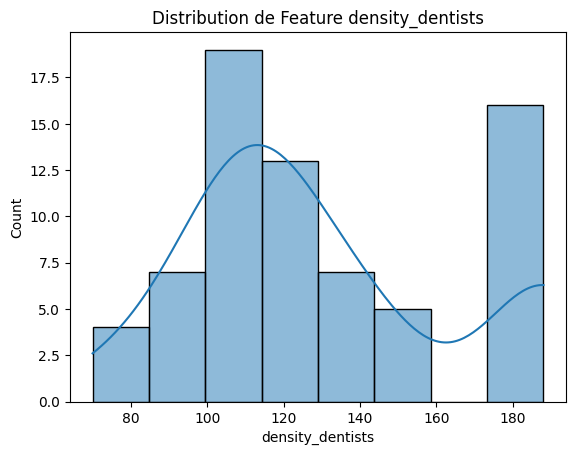

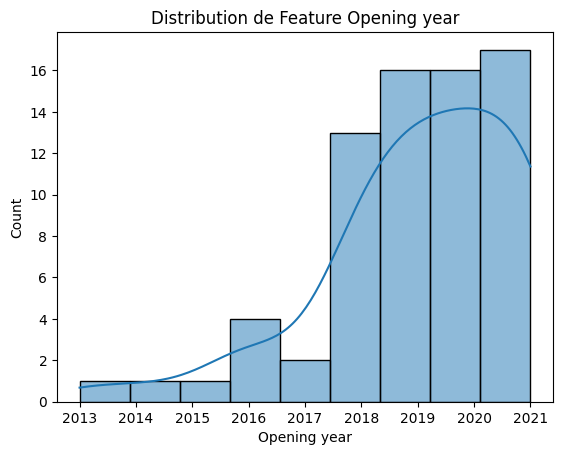

In [ ]:
for c in data.columns:
  sns.histplot(data[c], kde=True)
  plt.title('Distribution de Feature' +' ' + str(c))
  plt.show()

What we can say by looking at these distributions is that the feature distributions are generally symmetrical and not very skewed. Finally, the 'Revenue' feature has a significant outlier (revenue > 14), which might encourage us to apply a transformation. We will se the skewness of our data later in the preprocessing part.

In [ ]:
data[data['revenue']> 14]

,Latitude,Longitude,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,Opening year
69,50.616725,3.133466,15.0,0.19,4.0,46.0,4.891304,3484,24675.533216,0.04,9.05954,18853.333333,10.1,23.194949,166.0,55,113,2019


#### Discussion on the target to choose

Different strategies can be employed depending on the objectives of the dental center, where m is the margin and r the revenue :

- **Profit Maximization**:
$$
\text{profit} = \text{m} \times \text{r}
$$
- **profit per dentist full-time equivalent** :
$$
\text{Profit per Dentist} = \frac{m \times r}{\text{FTE}}
$$

- **Operational efficiency**:
$$
\text{Operational Efficiency} = \text{Margin}
$$
- **Custom performance metric created by applying PCA to certain previously shared features** or employing an alternative dimensionality reduction method.,
- ...
<br>

For the purposes of this analysis, we have chosen two main objectives: profit per dentist, acknowledging the flat hierarchy in dental practices where each dentist has a stake in the business and the goal is to increase gain for each dentist, and absolute margin, which aims to optimize the efficiency of the center. Given the business context, creating a PCA to represent a global performance feature would not be appropriate, as it may lack clarity and be difficult to explain.

Since it is always useful to examine whether a relationship exists between our target feature and each variable, we will create a pairplot to analyze this for each strategy (either r_margin or profit per dentist).

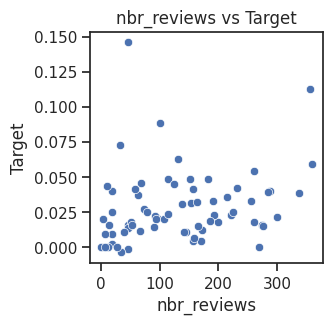

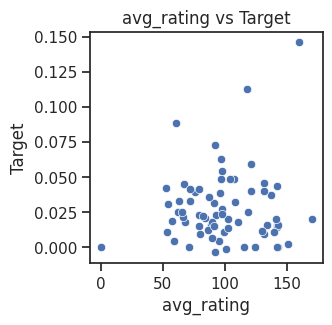

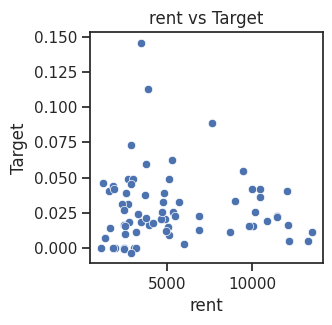

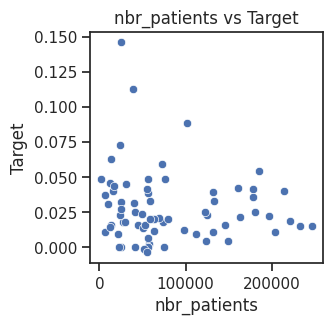

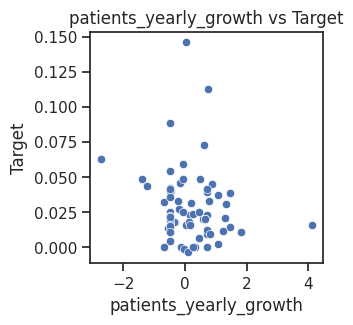

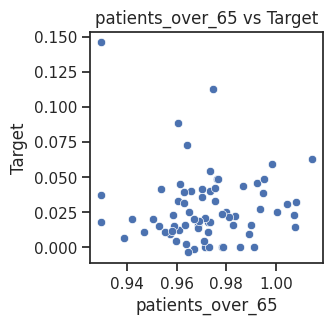

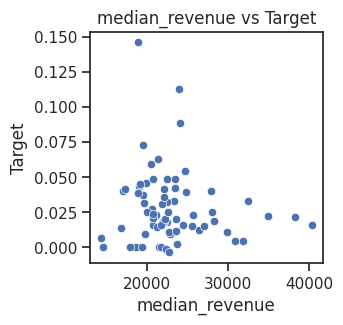

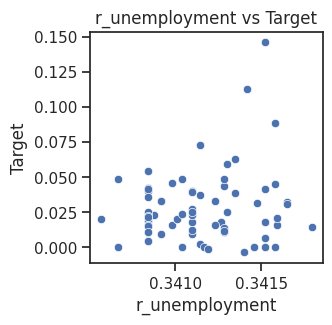

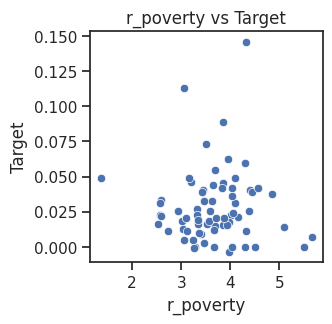

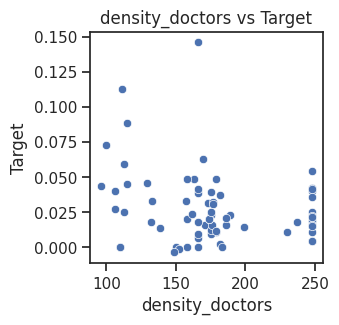

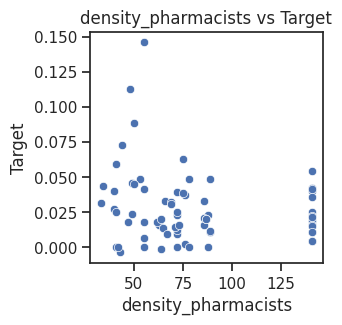

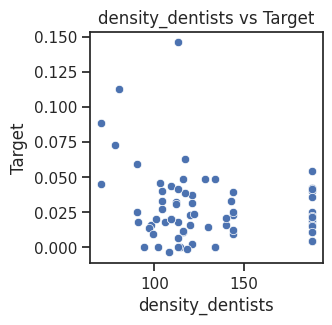

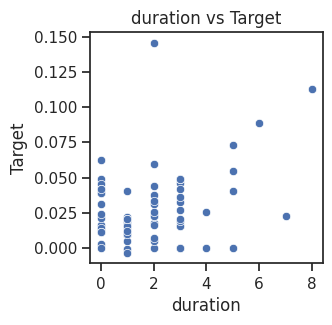

In [ ]:
# Here, we use the dataframes X1 and y1, which were preprocessed in question 2, where the target is profit per dentist full-time equivalent.

for feature in X1.columns:
    plt.figure(figsize=(3,3))
    sns.scatterplot(x=X1[feature], y=y1, marker='o')
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

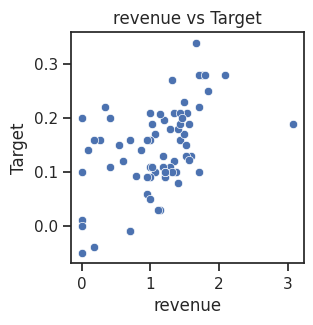

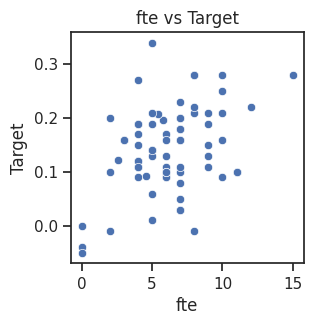

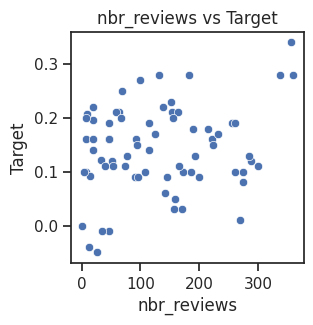

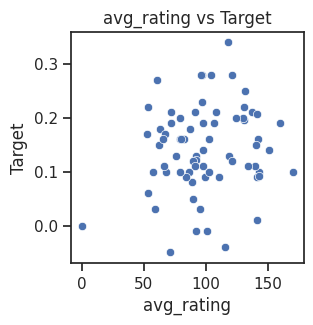

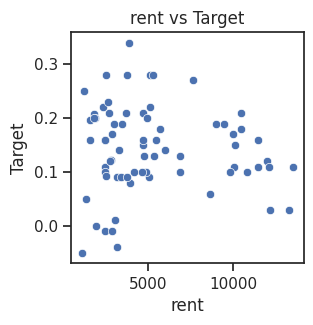

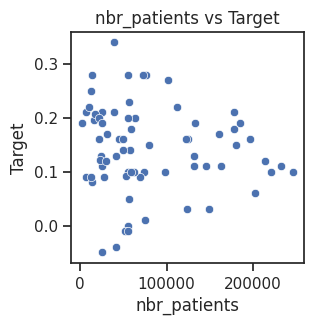

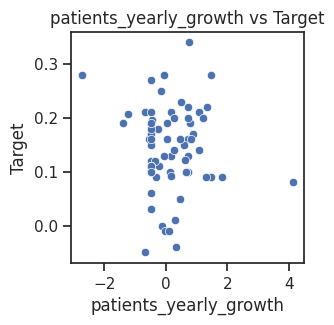

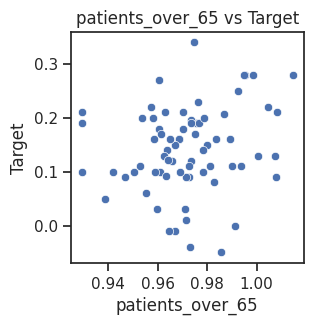

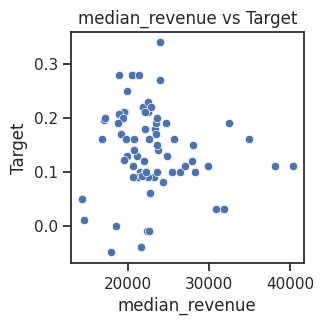

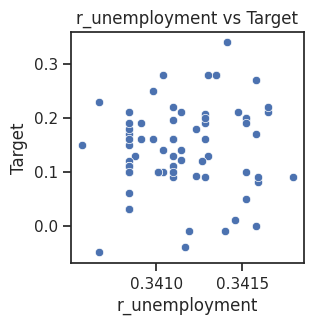

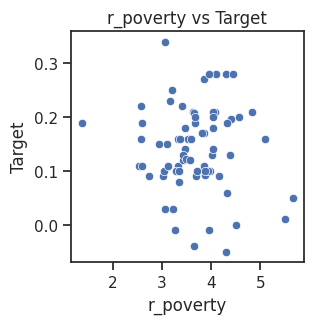

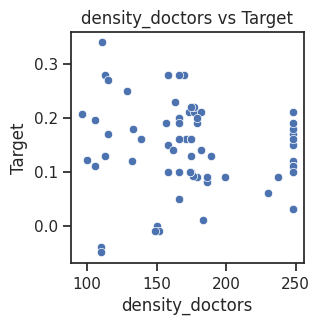

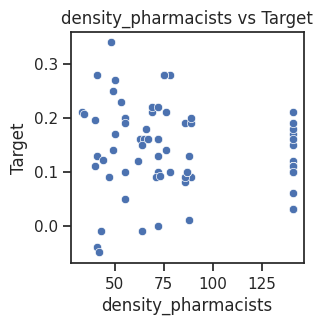

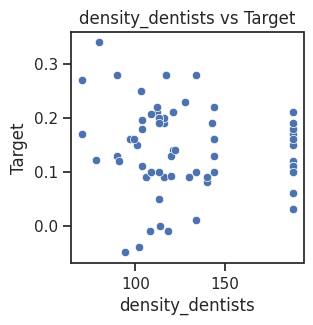

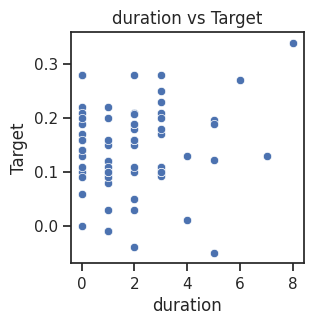

In [ ]:
# We use here X2,y2 dataframes, data frames preprocessed on question 2 when the target is profit per dentist full-time equivalent

for feature in X2.columns:
    plt.figure(figsize=(3,3))
    sns.scatterplot(x=X2[feature], y=y2, marker='o')
    plt.title(f'{feature} vs Target')
    plt.xlabel(feature)
    plt.ylabel('Target')
    plt.show()

Based on our analysis so far, there doesn’t appear to be a clear correlation between the features and the target variable across both strategies. This preliminary insight suggests that **Linear Regression and other simple models are unlikely to capture the complexity needed** for this task. Consequently, we will opt for more **robust models**, such as **Random Forest or XGBoost Regressor**, which are well-suited to handle non-linear relationships and complex interactions between variables. At the same time, we will **avoid deep learning models or those with an excessive number of parameters**, as our **dataset** is relatively **small** and may not support the complexity these models require.

## Question 2

Which variables **explain the largest share of center performance?** Are they rather linked to operational center performance or to the center's catchment area? Please try to **build a small supervised machine learning model** to support your findings.

Before starting the analysis, we assume that certain variables, such as the duration of consultations, the number of reviews, and possibly **internal aspects** like service quality, strongly influence the performance of the centers. This leads us to place particular importance on the internal factors of the firm. Moreover, **some variables are strongly correlated with performance (such as revenue and FTE). Therefore, it is important to consider them not as training variables, but rather as target variables.**
<br>

At the same time, it is quite evident that the location of the firm—whether in a low-density region or an oversaturated area—will also impact its performance. This raises an open question regarding the relative importance of internal versus external factors. While we expect **internal factors to play a significant role**, it is important to consider that the data may be somewhat **biased in favor of these internal elements**. Dentists often recognize the critical importance of selecting an optimal location for their practice, which could skew the data towards internal influences. <br>

To validate this intuition, we will apply supervised models. These models will help us quantify the importance of the various variables and confirm (or refute) the influence of internal factors. We will specifically rely on **feature importance** calculated by the models.

### Preprocessing and Data Engineering

Although our exercise is not a prediction task and, therefore, preprocessing may not seem as critical, I decided to pay particular attention to it out of a concern for detail. This is especially important when dealing with a limited dataset like ours, as ensuring the data is as homogeneous as possible is essential for robust analysis. <br><br>

The goal of identifying the most important features must remain a priority. While we might be tempted to perform PCA on the density features—combining the three different features into one—due to the relatively large number of variables compared to the length of the dataset, it is crucial to remember that **our objective is not prediction, but rather the evaluation of features**. Therefore, applying PCA in this context could prove to be more detrimental than beneficial. <br><br>

For this portion, we will **skip normalization, as it is not needed for model-based tree algorithms.** <br><br>  

That being said, we first addressed the missing values using two imputation strategies. The first strategy involved filling missing values with zero when the firm was newly established at the time of the study (2021). This approach is logical, as it accurately reflects the absence of recorded data for firms that had not yet generated revenue. The second strategy employed **K-Nearest Neighbors imputation**. This method is particularly suitable in our context, especially since we do not have significant concerns regarding **computational demand given the size of our dataset.**

In [ ]:
## See Question 1

data['density_doctors'] = data['density_doctors'].apply(lambda x: abs(x))

data.at[14, 'r_poverty'] = 12
data.at[30, 'r_unemployment'] = 25
data.at[28, 'nbr_reviews'],data.at[28, 'avg_rating'] = 269,4.7
data.at[59, 'nbr_reviews'],data.at[59, 'avg_rating'] = 27,3.7

In [ ]:
## See Question1
imputer_zero = SimpleImputer(fill_value = 0, strategy='constant')
data[(data['Opening year']== 2021) & (data['revenue'].isna())] =  imputer_zero.fit_transform(data[(data['Opening year']== 2021) \
                                                                                                                      & (data['revenue'].isna())])

imputer = KNNImputer(n_neighbors=5)
data_imputed = imputer.fit_transform(data)
data_transform = pd.DataFrame(data_imputed, columns=data.columns)

We have created a new feature: Duration. This decision was made because the information regarding the year when the revenue measurement was taken (2021) was not adequately represented in our data frame. Specifically, it was embedded in the name of an existing feature, which we have now renamed. Additionally, the opening year alone does not seem sufficient to explain performance effectively. Therefore, we created the Duration feature, defined as $$duration = 2021 - Opening Year$$ <br>
Furthermore, latitude and longitude alone do not provide directly usable data for the model. Instead, it would be more insightful to calculate the distance to the city center, using the Haversine formula, for instance. This approach allows us to derive meaningful spatial relationships that can enhance our analysis. Given the lack of additional indicators, I also decided to drop these features.




In [ ]:
##Feature engineering :

data_transform['duration'] = 2021 - data_transform['Opening year']
data_transform['duration'].describe()
data_transform = data_transform.drop('Opening year', axis = 1)

In [ ]:
data_transform = data_transform.drop(['Latitude', 'Longitude'], axis = 1)

Eventually, we focused on data skewness and outliers, as they are well-known to impact model performance. One of the few transformations we were able to implement was addressing this issue. Although Box-Cox and logarithmic transformations initially appeared suitable, they presented challenges due to the possibility of certain features having zero values (such as revenue). Additionally, clipping values at a small threshold like 1e-5 seemed inadequate given the units involved; for instance, 1e-3 of a million still corresponds to 1,000 euros, which is significant in our context.

In [ ]:
#As in Question 1
skewness_stats = data_transform.apply(lambda x: skew(x))
skewness = pd.DataFrame({
    'Value': skewness_stats
})
skewness

,Value
revenue,3.645731
r_margin,-0.147241
fte,0.231228
nbr_reviews,0.530835
avg_rating,-3.505653
rent,0.887607
nbr_patients,0.939119
patients_yearly_growth,0.899073
patients_over_65,1.770359
median_revenue,1.421315


In [ ]:
# yeojohnson_columns of skewed features :
# We put the threshold at 1.5

yeojohnson_columns = skewness[abs(skewness['Value']) > 1.5].index
for column in yeojohnson_columns:
    data_transform[column] = stats.yeojohnson(data_transform[column])[0]

In [ ]:
skewness_stats = data_transform[yeojohnson_columns].apply(lambda x: skew(x))

skewness_yj = pd.DataFrame({
    'Value': skewness_stats
})

skewness_yj

,Value
revenue,0.011947
avg_rating,-0.102840
patients_over_65,0.000358
r_unemployment,0.233343
r_poverty,0.039608


Here, we can observe the improvement, with the data appearing significantly less skewed.



### Target creation and model development.

**Given the limited size of our dataset, we conducted a grid search using relatively low values for the number of estimators and maximum depth. This approach is intended to avoid overfitting and ensure that our model generalizes well to unseen data.**

<br>
<br>

Regarding the metrics, even though we reduced the skewness of the data, we aimed to avoid metrics that are heavily impacted by outliers, such as MSE, especially considering the limited length of the dataset. Therefore, **we chose R² and MAE** as our evaluation metrics. R² provides an indication of how well our model explains the variability of the target variable, while MAE offers a straightforward measure of average error, making them more robust choices for our analysis.

####First strategy - profit per dentist full-time equivalent

We now want to train a model to identify which features are most relevant for predicting profit per dentist full-time equivalent. To achieve this, we’ll use a tree-based model with a limited number of trees and estimators, helping us reduce bias, and thus be **less sensitive to noise.**

<br>


Since we don't have much data, **boosting methods** like XGBoost or **bagging methods** like AdaBoostRegressor appear to be good choices. Both methods iteratively focus on reducing errors by giving more weight to samples that previous models misclassified, which helps enhance performance, especially on small datasets.

<br>

Among the various attempts and model selection processes, the AdaBoostRegressor method yielded the best results.

Note that **if FTE is null**, the profit per dentist is not defined. However, logically, if the FTE is null, there is no reason for the profit for dentists to be different from **zero**. Therefore, we’ve transformed y based on this reasoning.

In [ ]:
data_transform1 = data_transform.copy()

In [ ]:
# We create our target variable

data_transform1['target'] = (data_transform1['revenue'] * data_transform1['r_margin'])  /data_transform1['fte']

X1 = data_transform1.drop(['target','revenue','r_margin',"fte"], axis = 1)
y1 = data_transform1['target'].fillna(0).replace([np.inf, -np.inf], 0)

X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.1, random_state=42) # set dataset size is set low to get as much as possible information for training purpose

We chose **Leave-One-Out Cross-Validation** to evaluate our tree-based models because, although computationally demanding, it is highly **suitable for small datasets**. LOOCV enables each data point to serve as a **unique validation instance**, providing a fine-grained estimate of model performance while maximizing the use of available training data. The choice of metrics included Leave-One-Out, Leave-P-Out, and ShuffleSplit.
<br><br>

Moving forward, during each model training, we will utilize GridSearch from the Scikit-Learn library while considering the reduced size of our dataset. For every tree-based model, we will deliberately choose a relatively low depth and a limited number of weak learners to mitigate the risk of overfitting and minimize sensitivity to noise.


In [ ]:
tree = DecisionTreeRegressor()

model = AdaBoostRegressor(estimator=tree)

param_grid = {
    'n_estimators': [2, 3,4,5,6],  #number of weak learners (tree)
    'estimator__max_depth': [2, 3,4] # Depth of weak learners (tree)
}

loo = LeaveOneOut() # The behaviour of cross validation

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo, scoring='neg_median_absolute_error', verbose=1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print(f"Best Median Absolute Error: {best_score:.4f}")

# Make predictions and calculate the R² score on the test set
y_pred = grid_search.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R² Score: {r2:.4f}")

Fitting 63 folds for each of 15 candidates, totalling 945 fits
Best Parameters: {'estimator__max_depth': 3, 'n_estimators': 5}
Best Median Absolute Error: 0.0165
R² Score: 0.6753


In absolute terms, these hyperparameters may seem slightly high given the small size of our dataset. However, we trust the results of the grid search and will proceed with these parameters beacause of the relative good R2 score on the test set.

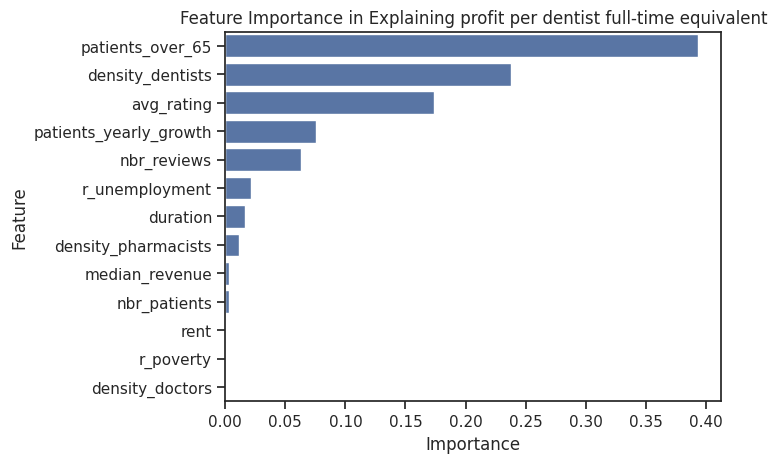

In [ ]:
# Use feature importance tool of tree based model

feature_importances = best_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X1.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance in Explaining profit per dentist full-time equivalent')
plt.show()

In [ ]:
importance_df

,Feature,Importance
5,patients_over_65,0.393215
11,density_dentists,0.238206
1,avg_rating,0.173962
4,patients_yearly_growth,0.075341
0,nbr_reviews,0.062755
7,r_unemployment,0.021510
12,duration,0.016780
10,density_pharmacists,0.011194
6,median_revenue,0.003349
3,nbr_patients,0.003210


Feature importance analysis is essential, but utilizing **SHAP** and **PDP** **provides a deeper understanding of the model's behavior**, helping us avoid incorrect conclusions. For instance, PDP illustrates how a feature influences predictions while keeping others constant. Although our variables are clear, these tools offer additional insights into interactions and allow us to avoid misunderstandings.

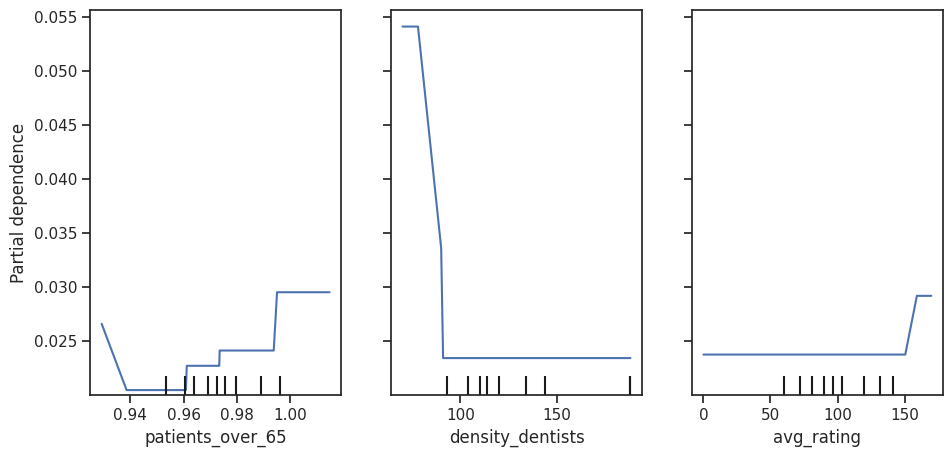

In [ ]:
features_to_plot = list(importance_df['Feature'])[:3] # We only analyze features that have the maximum importance
# Creation of our Partial Dependence Plot
fig, ax = plt.subplots(figsize=(11, 5))
PartialDependenceDisplay.from_estimator(best_model, X_train, features_to_plot, ax=ax)
plt.show()

This analysis clearly shows a **positive correlation** between the **number of patients over 65** in the catchment area and the **performance** of the dental clinic, as indicated by the PDP analysis. This is logical since older individuals generally have more financial resources and are more likely to invest in their health than younger individuals, who are often in better health.
<br>

Another intuitive finding is the negative effect of dentist density on the clinic's performance, which can be attributed to **competition.**

##### conclusion for the strategy one  

From this point forward, we can conclude that the number of patients over 65 is by far the most important feature, accounting for 40% of the overall importance. This is logical, as older individuals typically have more healthcare needs and tend to visit doctors more frequently than younger patients.

<br>

Furthermore, we can observe a second significant breakpoint at the median income level, which is the eighth most important feature. Therefore, we can conclude that the features patients_yearly_growth, density_pharmacists, r_poverty, rent, and r_unemployment are relatively less relevant.

<br>


Finally, when examining the top eight features, we note an equal distribution between catchment area features and operational features (4 each).

####  Second strategy - Operational Efficiency

We now want to train a model to identify which features are most relevant for **predicting operational efficiency**. To achieve this, we will do as previously using a grid search cross validation with AdaBoostRegressor.

In [ ]:
data_transform_s2 = data_transform.copy() # data transform copy for strategy 2

In [ ]:
# We create our target variable

X2 = data_transform_s2.drop(['r_margin',], axis = 1)
y2 = data_transform_s2['r_margin']

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=42)

In [ ]:
# Same as strategy one

tree2 = DecisionTreeRegressor()

model2 = AdaBoostRegressor(estimator=tree2)

param_grid = {
    'n_estimators': [2, 3,4,5,6,7],
    'estimator__max_depth': [2, 3,4]
}

loo = LeaveOneOut()

grid_search2 = GridSearchCV(estimator=model, param_grid=param_grid, cv=loo, scoring='neg_median_absolute_error', verbose=1)

grid_search2.fit(X_train2, y_train2)

best_model2 = grid_search2.best_estimator_
best_params2 = grid_search2.best_params_
best_score2 = -grid_search2.best_score_

print("Best Parameters:", best_params2)
print(f"Best Median Absolute Error: {best_score2:.4f}")

y_pred2 = grid_search2.predict(X_test2)
r2 = r2_score(y_test2, y_pred2)
print(f"R² Score: {r2:.4f}")

Fitting 63 folds for each of 18 candidates, totalling 1134 fits
Best Parameters: {'estimator__max_depth': 3, 'n_estimators': 3}
Best Median Absolute Error: 0.0541
R² Score: 0.1377


The R² score here is somewhat lower, which means we should be more cautious when interpreting the results and drawing conclusions especially when dealing with small dataset.

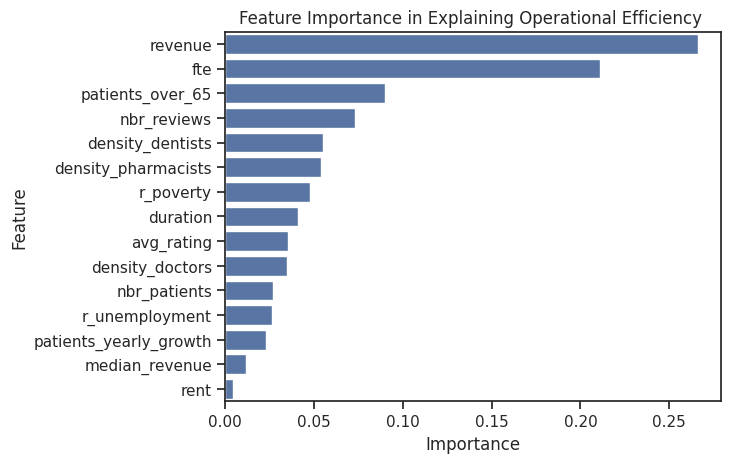

In [ ]:
feature_importances2 = best_model2.feature_importances_
importance_df2 = pd.DataFrame({'Feature': X2.columns, 'Importance': feature_importances2})
importance_df2 = importance_df2.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=importance_df2)
plt.title('Feature Importance in Explaining Operational Efficiency ')
plt.show()

In [ ]:
importance_df2

,Feature,Importance
0,revenue,0.265957
1,fte,0.210735
7,patients_over_65,0.089682
2,nbr_reviews,0.072910
13,density_dentists,0.054878
12,density_pharmacists,0.054132
10,r_poverty,0.047930
14,duration,0.041105
3,avg_rating,0.035413
11,density_doctors,0.034794


##### Conclusion

Logically, the characteristics of revenue and FTE (full-time equivalent) have the greatest influence on the clinic's operating margin. In contrast, factor such as **average rating is less significant**. Additionally, we observe that the duration, such as the time since the clinic opened from 2021 onwards, is much more important for this target than for profit. It is reasonable to assume that the longer the clinic has been open, the lower the likelihood that it still has outstanding loans to repay, for instance.

<br>

Furthermore, we note that the feature importances are **more evenly distributed**, with the most significant feature accounting for only 30% of the importance, down from 40% in the first strategy. Nevertheless, the age group of patients over 65 remains a key feature driving performance.

## Question 3

Use an unsupervised learning technique to **cluster the dental centers**. How would you describe each cluster to the client in business terms?

For this part, we have decided to evaluate the optimal number of clusters k using the **silhouette score**, a commonly used metric for assessing the quality of clustering. The silhouette score measures how similar an object is to its own cluster compared to other clusters. The score ranges from -1 to 1, where a high value indicates that points are well clustered. A silhouette score close to 1 suggests that the data points are appropriately clustered, while a score near 0 indicates that the points are on or very close to the decision boundary between clusters. Negative values suggest that points may have been assigned to the wrong cluster.

<br>

Furthermore, we use **Spectral Clustering** because it is particularly effective for identifying clusters in complex datasets where the clusters may not be spherical or well-separated. Unlike traditional clustering algorithms like K-Means, which rely on the assumption of spherical clusters and equal variance, Spectral Clustering uses the eigenvalues of a similarity matrix to reduce dimensionality before applying a clustering algorithm. This approach enables it to capture the underlying structure of the data more effectively, particularly in cases where clusters are interconnected.

It is crucial not to make the mistake of failing to standardize our data before applying clustering. These models are indeed very sensitive to scale effects. Therefore, we will adopt a standardized approach by using **StandardScaler** from the Scikit-Learn library.

In [ ]:
data_transform_clustering = data_transform.copy()

scaler = StandardScaler()
data_transform_clustering = pd.DataFrame(scaler.fit_transform(data_transform_clustering), columns=data_transform_clustering.columns)

In [ ]:
best_score = -1 # Initialize with the lowest possible value of the silhouette score
best_k = 0

for k in range(2, 9): # number of clusters

    clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)  # similarity between points should be calculated from the nearest neighbors.
    labels = clustering.fit_predict(data_transform_clustering)

    score = silhouette_score(data_transform_clustering, labels)
    print(f"Nombre de clusters: {k}, Score de silhouette: {score}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Meilleur nombre de clusters : {best_k} avec un score de silhouette de : {best_score}")

Nombre de clusters: 2, Score de silhouette: 0.31639936248610717
Nombre de clusters: 3, Score de silhouette: 0.21172494615670254
Nombre de clusters: 4, Score de silhouette: 0.18876391520131666
Nombre de clusters: 5, Score de silhouette: 0.15666910321260838
Nombre de clusters: 6, Score de silhouette: 0.16422185941221015
Nombre de clusters: 7, Score de silhouette: 0.11810525818185251
Nombre de clusters: 8, Score de silhouette: 0.128391247306129
Meilleur nombre de clusters : 2 avec un score de silhouette de : 0.31639936248610717


The most appropriate number of clusters is clearly 2. In fact, observing the silhouette score difference suggests that clustering our data is highly relevant. To confirm this observation, we will perform an ANOVA analysis to identify the most discriminating variable.

In [ ]:
clustering = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', random_state=42)
labels = clustering.fit_predict(data_transform_clustering)

# Ajouter les labels aux données pour analyse
df = pd.DataFrame(data_transform_clustering, columns=data_transform.columns)  # Remplacez par les noms réels de vos colonnes
df['Cluster'] = labels

Here we use P-values. In clustering help assess the statistical significance of clusters, ensuring that observed patterns are meaningful rather than due to chance. They can also aid in feature selection by identifying influential variables, and in comparing different clustering solutions to determine the best model. This enhances the interpretability and robustness of clustering results.

In [ ]:
# Look at which variable was the most determinant

p_values = {}

for column in df.columns[:-1]:  # Ignorez la première colonne qui est 'Population'
    groups = [group[column].values for name, group in df.groupby('Cluster')]
    F_stat, p_value = stats.f_oneway(*groups)
    p_values[column] = p_value

# Sort to get the feature with the lowest p_value,
# meaning it is the one that has the strongest association
# with the target variable and is likely the most significant in determining the clustering outcome.

p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [ ]:
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [ ]:
p_values_df

,Variable,p_value
13,density_pharmacists,2.069280e-28
14,density_dentists,9.481361e-25
5,rent,1.445513e-24
6,nbr_patients,2.788557e-21
12,density_doctors,1.440853e-18
9,median_revenue,1.554851e-09
10,r_unemployment,1.141261e-07
7,patients_yearly_growth,7.952838e-04
3,nbr_reviews,2.457138e-02
4,avg_rating,3.118831e-02


In other words, the features 'density_pharmacists', 'density_dentists', 'rent', and 'nbr_patient in catchment area' are the most significant in challenging the null hypothesis. Collectively, these features reflect the overall population density, indicating that variations in patient numbers within the catchment area are likely to affect the clustering results.

In [ ]:
most_discriminant_variable = p_values_df.iloc[0]
print(f"Variable la plus discriminante : {most_discriminant_variable['Variable']}, p-value : {most_discriminant_variable['p_value']}")

Variable la plus discriminante : density_pharmacists, p-value : 2.0692795684103127e-28


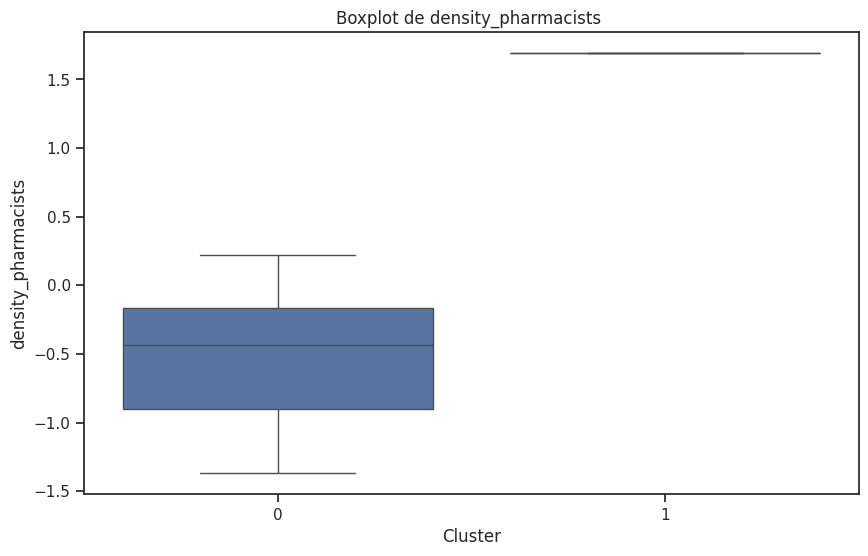

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y=most_discriminant_variable['Variable'], data=df)
plt.title(f'Boxplot de {most_discriminant_variable["Variable"]} ')
plt.show()

The cabinets will therefore be categorized into two possible categories:


*   High-demand centers: Located in densely populated areas, they experience a lot of demand.

*  Low-demand centers :  Located in areas with low population density, these centers often stand out due to their specialization.





## Question 4

Let's **enrich our dataset** with additional data on competition. Download the following file providing an overview of all medical institutions in France with their geo coordinates and convert it to a clean dataframe: https://www.data.gouv.fr/fr/datasets/r/98f3161f-79ff-4f16-8f6a-6d571a80fea2.

Perform the necessary **filters to separate dental centers** from the other institutions.

**Reproject the geo coordinates** to the ESPG:4326 coordinate reference system (same as the coordinates in the dental center dataset).

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

This dataset consists of numerous medical institutions in France (both Metropolitan and in the DOM-TOM regions), along with their geographical coordinates and several other details not relevant to our task, identified by their geographical FINESS ID (FINESS ET) and their legal FINESS ID (FINESS EJ).

In [ ]:
data_concu = pd.read_csv('etalab-cs1100507-stock-20240909-0338.csv',sep = ';').reset_index().drop("2024-09-09",axis =1)

<ipython-input-80-71ec6a7220ee>:1: DtypeWarning: Columns (1,2,3,6,8,9,10,11,13,14,15,19,21,23,25,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  data_concu = pd.read_csv('etalab-cs1100507-stock-20240909-0338.csv',sep = ';').reset_index().drop("2024-09-09",axis =1)


In [ ]:
data_concu.columns = ['finess', 'FinessET', 'FinessEJ', 'RaisonSociale', 'RaisonSocialeLongue',
       'ComplementRaisonSociale', 'ComplementDistribution', 'NumRue',
       'TypeRue', 'NomRue', 'c6', 'c7', 'c8', 'numDep', 'dep',
       'LigneAcheminement', 'Telephone', 'Telecopie',
       'CodeCategorieEtablissement', 'NomCategorieEtablissement',
       'NumCategorieAgragat', 'LieblleCategorieAgregat', 'NumleroSiret',
       'CodeAPE', 'CodeMFT', 'Libelle MFT', 'Code SPH', 'libelle SPH',
       'dateOuverture', 'Date d’autorisation',
       'Date de mise à jour de la structure']
data_concu.columns # We rename columns for easier manipulation later on.

Index(['finess', 'FinessET', 'FinessEJ', 'RaisonSociale', 'RaisonSocialLongue',
       'ComplementRaisonSociale', 'ComplementDistribution', 'NumRue',
       'TypeRue', 'NomRue', 'c6', 'c7', 'c8', 'numDep', 'dep',
       'LigneAcheminement', 'Telephone', 'Telecopie',
       'CodeCategorieEtablissement', 'NomCategorieEtablissement',
       'NumCategorieAgragat', 'LieblleCategorieAgregat', 'NumleroSiret',
       'CodeAPE', 'CodeMFT', 'Libelle MFT', 'Code SPH', 'libelle SPH',
       'dateOuverture', 'Date d’autorisation',
       'Date de mise à jour de la structure'],
      dtype='object')

In [ ]:
# First, we create two tables, which we will then join on the FINESS ET feature

data_geo = data_concu[data_concu['finess'] == 'geolocalisation'].drop('finess', axis = 1)
data_struct = data_concu[data_concu['finess'] == 'structureet'].drop('finess', axis = 1)

In [ ]:
print(len(data_geo),len(data_struct))

100462 100462


In [ ]:
data_geo.to_csv('data_geo.csv')
data_struct.to_csv('data_struct.csv')

####Prepoprocessing of our data_geo table

The goal here is to convert the coordinate system to EPSG:4326, noting that coordinates are currently expressed in six possible systems, depending on the region. For example, a location in Metropolitan France is projected in EPSG:2154, while a location in Mayotte is expressed in EPSG:4471.

In [ ]:
#Drop any columns that are not of interest.

data_geo = data_geo.drop(['ComplementRaisonSociale','ComplementDistribution','c6','c7','Telephone',\
                            'Telecopie','NumleroSiret','CodeMFT','Libelle MFT','Code SPH','libelle SPH',\
                          "NomRue",'TypeRue','NumRue','c8','numDep','dep','LigneAcheminement','CodeCategorieEtablissement',\
                          'NomCategorieEtablissement','NumCategorieAgragat','NumCategorieAgragat','LieblleCategorieAgregat',\
                          'CodeAPE','dateOuverture','Date d’autorisation','Date de mise à jour de la structure'], axis = 1)

In [ ]:
data_geo.rename(columns={'FinessEJ' : 'coordonnée_x', 'RaisonSociale': 'coordonnée_y','RaisonSocialeLongue' : "systeme" ,'FinessET': 'finess_geo'}, inplace=True)

In [ ]:
data_geo['systeme'] = data_geo[['systeme']].astype(str)

In [ ]:
data_geo['systeme']

,systeme
100462,"1,ATLASANTE,81,BAN_05-09-2024,LAMBERT_93_METRO..."
100463,"1,ATLASANTE,81,BAN_05-09-2024,LAMBERT_93_METRO..."
100464,"2,ATLASANTE,100,BDADRESSE_v2.2_03-2024,LAMBERT..."
100465,"1,ATLASANTE,100,BDADRESSE_v2.2_03-2024,LAMBERT..."
100466,"1,ATLASANTE,85,BAN_05-09-2024,LAMBERT_93_METRO..."
...,...
200919,"4,ATLASANTE,.,ADMIN-EXPRESS-2023,UTM_S38_MAYOTTE"
200920,"2,ATLASANTE,87,BDADRESSE_v2.2_03-2024,UTM_S38_..."
200921,"1,ATLASANTE,85,BAN_05-09-2024,UTM_S38_MAYOTTE"
200922,"4,ATLASANTE,.,ADMIN-EXPRESS-2023,UTM_S38_MAYOTTE"


In [ ]:
# We only want to retrieve the system in which the coordinates are expressed
data_geo['systeme'] = data_geo['systeme'].apply(lambda x: x.split(',')[-1])

In [ ]:
#NaN values are present because no coordinate system was entered

data_geo['systeme'].unique()

array(['LAMBERT_93_METROPOLE', 'nan', 'UTM_N20_ANTILLES',
       'UTM_N22_GUYANE', 'UTM_S40_LA_REUNION',
       'UTM_N21_STPIERRE-MIQUELON', 'UTM_S38_MAYOTTE'], dtype=object)

In [ ]:
# Encoding coordinate systems according to their appropriate code

map_systeme = {
  'LAMBERT_93_METROPOLE' : 'EPSG:2154',
  'UTM_N20_ANTILLES' : 'EPSG:4559',
  'UTM_N22_GUYANE' : 'EPSG:2972',
  'UTM_S40_LA_REUNION' : 'EPSG:2975',
  'UTM_N21_STPIERRE-MIQUELON' : 'EPSG:4467',
  'UTM_S38_MAYOTTE' : 'EPSG:4471'
            }

def system_convertor(x):
    src_epsg = map_systeme.get(x['systeme'])
    if src_epsg is None:
        print(x['systeme'])
        return None, None
    transformer = Transformer.from_crs(src_epsg, "EPSG:4326", always_xy=True)
    return transformer.transform(x['coordonnée_x'], x['coordonnée_y'])

data_geo['(longitude,latitude)'] = data_geo.apply(system_convertor, axis=1)
data_geo = data_geo.drop(['coordonnée_x', 'coordonnée_y', 'systeme'], axis=1)

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [ ]:
data_geo["longitude"] = data_geo["(longitude,latitude)"].apply(lambda x: x[0])
data_geo["latitude"] = data_geo["(longitude,latitude)"].apply(lambda x: x[1])
data_geo = data_geo.drop('(longitude,latitude)', axis = 1)

In [ ]:
data_geo.head()

,finess_geo,longitude,latitude
100462,10000024,5.208387,46.222647
100463,10000032,5.679892,45.748331
100464,10000065,4.771957,45.941074
100465,10000081,6.057731,46.322338
100466,10000099,5.194669,45.906630


####Prepoprocessing of our data_struct table

Here, we aim to select only the dental centers, so we need to identify a method or feature to accomplish this. Notably, selection by APE code appears too restrictive, as we seem interested in all types of competitors. For instance, a clinic offering dental care as a secondary service would be excluded (since the APE code reflects the primary activity only). Take the example of the healthcare center with FINESS ET number 380027151

In [ ]:
data_struct[data_struct["FinessET"]== 380027151]

,FinessET,FinessEJ,RaisonSociale,RaisonSocialLongue,ComplementRaisonSociale,ComplementDistribution,NumRue,TypeRue,NomRue,c6,...,LieblleCategorieAgregat,NumleroSiret,CodeAPE,CodeMFT,Libelle MFT,Code SPH,libelle SPH,dateOuverture,Date d’autorisation,Date de mise à jour de la structure
34519,380027151,380027144,CENTRE DE SANTE DENTAIRE VERTUO,CENTRE DE SANTE DENTAIRE VERTUO,NaN,NaN,1.0,R,DES ABATTOIRS,NaN,...,Centres de Santé,9.195290e+13,8899B,36.0,Tarifs conventionnels assurance maladie,NaN,NaN,2023-09-04,2023-03-03,2023-09-04


It is registered with APE code 8899B, which corresponds to 'Other Social Work Activities Without Accommodation' and not to dental practice (APE code 8623Z), even though it is indeed a dental health center. Similarly, filtering by establishment category or aggregate category number does not seem to be a reliable solution.

<br>

**However, it should be noted that this depends once again on the clinic's strategy.**

 <br>


For this exercise, and in the absence of further guidance, we will filter by the company name. If it contains the word 'dental' or 'dent,' we will keep it; otherwise, we will exclude it. By doing so, we identify 1,126 clinics instead of 760 when filtering by APE code.

In [ ]:
data_struct.head()

,FinessET,FinessEJ,RaisonSociale,RaisonSocialLongue,ComplementRaisonSociale,ComplementDistribution,NumRue,TypeRue,NomRue,c6,...,LieblleCategorieAgregat,NumleroSiret,CodeAPE,CodeMFT,Libelle MFT,Code SPH,libelle SPH,dateOuverture,Date d’autorisation,Date de mise à jour de la structure
0,10000024,10780054,CH DE FLEYRIAT,CENTRE HOSPITALIER DE BOURG-EN-BRESSE FLEYRIAT,NaN,NaN,900.0,RTE,DE PARIS,NaN,...,Centres Hospitaliers,2.601000e+13,8610Z,3.0,ARS établissements Publics de santé dotation g...,1.0,Etablissement public de santé,1979-02-13,1979-02-13,2020-02-04
1,10000032,10780062,CH BUGEY SUD,CENTRE HOSPITALIER BUGEY SUD,NaN,NaN,700.0,AV,DE NARVIK,NaN,...,Centres Hospitaliers,2.601000e+13,8610Z,3.0,ARS établissements Publics de santé dotation g...,1.0,Etablissement public de santé,1901-01-01,1901-01-01,2021-07-07
2,10000065,10780096,CH DE TREVOUX - MONTPENSIER,CENTRE HOSPITALIER DE TREVOUX - MONTPENSIER,NaN,NaN,14.0,R,DE L'HOPITAL,NaN,...,Centres Hospitaliers,2.601003e+13,8610Z,3.0,ARS établissements Publics de santé dotation g...,1.0,Etablissement public de santé,1901-01-01,1901-01-01,2018-01-12
3,10000081,10780112,CH DU PAYS DE GEX,CENTRE HOSPITALIER DU PAYS DE GEX,NaN,NaN,160.0,R,MARC PANISSOD,NaN,...,Hôpitaux Locaux,2.601001e+13,8610Z,3.0,ARS établissements Publics de santé dotation g...,1.0,Etablissement public de santé,1901-01-01,1901-01-01,2020-02-04
4,10000099,10780120,CH DE MEXIMIEUX,CENTRE HOSPITALIER DE MEXIMIEUX,NaN,NaN,13.0,AV,DU DOCTEUR BOYER,NaN,...,Hôpitaux Locaux,2.601001e+13,8610Z,3.0,ARS établissements Publics de santé dotation g...,1.0,Etablissement public de santé,1945-01-01,1945-01-01,2020-06-30


In [ ]:
#Create a feature adress
data_struct['NumRue'] = data_struct['NumRue'].astype(str)
data_struct['TypeRue'] = data_struct['TypeRue'].astype(str)
data_struct['NomRue'] = data_struct['NomRue'].astype(str)

data_struct['adresse'] = data_struct[['NumRue','TypeRue', 'NomRue']].agg(' '.join, axis=1)

data_struct = data_struct.drop(['NumRue','TypeRue', 'NomRue'],axis = 1)

In [ ]:
data_struct.rename(columns={'FinessET' : 'finess_geo'}, inplace=True)

In [ ]:
# Drop any columns that are not of interest.
data_struct = data_struct.drop(['ComplementRaisonSociale','ComplementDistribution','c6','c7','numDep','Telephone',\
                                'Telecopie','NumleroSiret','CodeMFT','Libelle MFT','Code SPH','libelle SPH'], axis = 1)

In [ ]:
data_struct = data_struct[data_struct['RaisonSocialLongue'].str.contains('dentaire|dent', case=False, na=False)]
data_struct = data_struct.drop(['c8','CodeCategorieEtablissement','NomCategorieEtablissement','NumCategorieAgragat', \
                                      'LieblleCategorieAgregat','CodeAPE','RaisonSociale','dep','LigneAcheminement',], axis = 1)

In [ ]:
data_struct.head()

,finess_geo,FinessEJ,RaisonSocialLongue,dateOuverture,Date d’autorisation,Date de mise à jour de la structure,adresse
457,10011468,10011450,CENTRE DE SANTE DENTAIRE FERNEY-VOLTAIRE,2019-07-15,2018-07-19,2024-01-12,26.0 AV VOLTAIRE
513,10012425,920037751,CENTRE DE SANTE DENTAIRE CLEMENCEAU,2021-12-01,2021-08-12,2021-12-01,12.0 AV CLEMENCEAU
516,10012482,10012474,CENTRE DE SANTE DENTAIRE D'OYONNAX,2021-10-15,2021-09-09,2023-09-15,31.0 BD LOUIS DUPUY
525,10012656,10012649,CENTRE DE SANTE DENTAIRE DE SAINT GENIS POUILLY,2022-08-18,2022-08-18,2023-08-31,34.0 R DU MONT BLANC
550,10013084,10013076,CENTRE DE SANTE MEDICO-DENTAIRE VALSERHONE,2023-10-17,2023-10-17,2023-10-17,25.0 R DE LA REPUBLIQUE


####Merge

In [ ]:
data2 = pd.merge(data_geo, data_struct, on='finess_geo', how='inner') # we merge on the Finess ET feature

In [ ]:
print(len(data2))

1104


In [ ]:
data2.head()

,finess_geo,longitude,latitude,FinessEJ,RaisonSocialLongue,dateOuverture,Date d’autorisation,Date de mise à jour de la structure,adresse
0,10011468,6.111825,46.257763,10011450,CENTRE DE SANTE DENTAIRE FERNEY-VOLTAIRE,2019-07-15,2018-07-19,2024-01-12,26.0 AV VOLTAIRE
1,10012425,5.651367,46.255845,920037751,CENTRE DE SANTE DENTAIRE CLEMENCEAU,2021-12-01,2021-08-12,2021-12-01,12.0 AV CLEMENCEAU
2,10012482,5.650842,46.258150,10012474,CENTRE DE SANTE DENTAIRE D'OYONNAX,2021-10-15,2021-09-09,2023-09-15,31.0 BD LOUIS DUPUY
3,10012656,6.027794,46.255077,10012649,CENTRE DE SANTE DENTAIRE DE SAINT GENIS POUILLY,2022-08-18,2022-08-18,2023-08-31,34.0 R DU MONT BLANC
4,10013084,5.827317,46.107727,10013076,CENTRE DE SANTE MEDICO-DENTAIRE VALSERHONE,2023-10-17,2023-10-17,2023-10-17,25.0 R DE LA REPUBLIQUE


In [ ]:
data2.to_csv('data2.csv')

Therefore, we can add 1,104 additional entries, which does not seem unreasonable when cross-referencing the information online.

## Question 5

Let's **assess competitive intensity** around the dental centers. First **draw a circle with a 500 meter radius** around each of the 71 dental center (under the form of a POLYGON). We will refer to these shapes as center catchment areas.
Then, **compute the number of competitors**, i.e. dental centers from the dataset you built in question 4 within each catchment area. Name this variable competitive intensity.

*Hint: to perform operations on coordinates, the libraries shapely, geopandas and pyproj might be helpful*

To compute the competitive intensity we can count using a spatial join, to see how many other dental centers fall within each center's 500-meter catchment area. We have to keep in mind that how many other cabinet are there in the catchment is not in its own the competitive intensity parameter. Indeed, it can also depends of the density of population in this area for example.

In [ ]:
data= pd.read_excel('20231124_dental_center_data 1.xlsx')

To tackle this exercice we will work using EPSG:2154 or Lambert-93 system, since it is well-suited for tasks requiring measurements in meters, as it is a projected coordinate system specifically designed for accurate distance and area calculations across France.

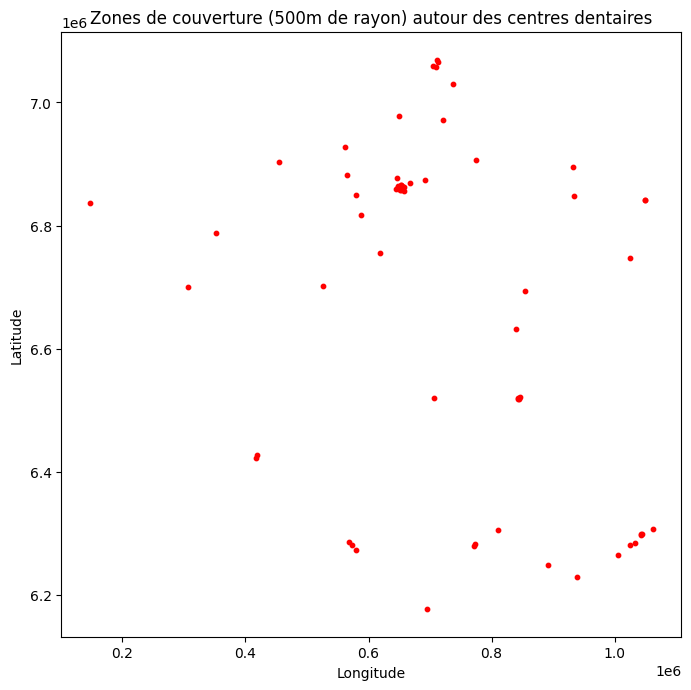

In [ ]:
# We are using a geo Dataframe from geopandas to tackle this exercice
# It is indeed relevant to make innner spatial join !

gdf_centers = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data.Longitude, data.Latitude),
    crs="EPSG:4326"
)

gdf_centers = gdf_centers.to_crs("EPSG:2154") #conversion for meter measurements
gdf_centers['buffer'] = gdf_centers.geometry.buffer(500) # create a polygon geometry

fig, ax = plt.subplots(figsize=(8, 8))
gdf_centers['buffer'].plot(ax=ax, color='lightblue', edgecolor='blue', alpha=0.5)

gdf_centers.plot(ax=ax, color='red', markersize=10)

plt.title("Zones de couverture (500m de rayon) autour des centres dentaires")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

plt.show()

In [ ]:
#Create spatial point corresponding to the location of competitor and then spacially join them if they are within a polygon from gdf_centers

gdf_competitors = gpd.GeoDataFrame(
    data2, geometry=gpd.points_from_xy(data2.longitude, data2.latitude), crs="EPSG:4326"
)
gdf_competitors = gdf_competitors.to_crs("EPSG:2154") #conversion for meters measurements

gdf_centers.set_geometry("buffer", inplace=True)

# The competitor is joined if its point is within the circle
join_result = gpd.sjoin(gdf_centers, gdf_competitors, how="left")

competitive_intensity = join_result.groupby('ID').size()

gdf_centers['competitive_intensity'] = gdf_centers['ID'].map(competitive_intensity).fillna(0)

In [ ]:
print(gdf_centers.competitive_intensity.describe())

count    71.000000
mean      1.704225
std       0.962057
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max       4.000000
Name: competitive_intensity, dtype: float64


In [ ]:
gdf_centers[['competitive_intensity']].value_counts()

,count
competitive_intensity,
1,42
3,13
2,12
4,4


Therefore, we can conclude that, **on average**, centers associated with this private dental clinic have **1.7 other clinics within a 500-meter radius**. At most, this number can reach up to 4, which pertains to 4 of our dental clinics. This description of the feature appears to align with reality.

## Question 6

Now let's **perform the explanatory analysis of question 2 and the clustering of question 3 again**, taking competitive intensity into account. Do the results change, and if so how and why?

For the sake of consistency, I’m reusing the same DataFrame, data_transform, from my initial analysis, now including the competitive intensity feature.

In [ ]:
data_transform_q6 = data_transform.copy()

In [ ]:
data_transform_q6['competitive_intensity'] = gdf_centers['competitive_intensity'] ## Adding competitive intensity feature

In [ ]:
data_transform_q6.head()

,revenue,r_margin,fte,nbr_reviews,avg_rating,rent,nbr_patients,patients_yearly_growth,patients_over_65,median_revenue,r_unemployment,r_poverty,density_doctors,density_pharmacists,density_dentists,duration,competitive_intensity
0,1.279951,0.18,7.0,190.0,63.113205,5731.0,58874.899010,-0.24,0.960656,23330.857143,0.341231,3.465195,133.0,66.0,104.0,2.0,1
1,1.342566,0.21,9.0,153.0,90.893169,2708.0,39687.660222,0.18,0.963138,19647.037037,0.341478,4.087760,173.0,33.0,121.0,2.0,4
2,1.538882,0.21,10.0,163.0,108.079245,4751.0,25370.677794,-0.68,1.008128,22524.666667,0.341652,3.629311,177.0,69.0,112.0,3.0,4
3,1.213822,0.09,10.0,145.0,98.863737,3205.0,6945.136108,1.83,0.946844,23213.333333,0.341286,2.726843,179.0,89.0,116.0,1.0,1
4,1.430689,0.21,8.0,63.0,137.091816,3707.0,6992.074760,1.08,0.929512,19480.000000,0.341145,4.839934,182.0,76.0,121.0,2.0,2


### Explanatory analysis when Competitiveness is Taken into Account

We use the exact same approach as in Question 2 to evaluate feature relevance.

#### First strategy

In [ ]:
data_transform_q6_s1 = data_transform_q6.copy()

In [ ]:
# We create our target variable

data_transform_q6_s1['target'] = (data_transform_q6_s1['revenue'] * data_transform_q6_s1['r_margin'])  /data_transform_q6_s1['fte']

X61 = data_transform_q6_s1.drop(['target','revenue','r_margin',"fte"], axis = 1)
y61 = data_transform_q6_s1['target'].fillna(0).replace([np.inf, -np.inf], 0)

X_train61, X_test61, y_train61, y_test61 = train_test_split(X61, y61, test_size=0.1, random_state=42) # set dataset size is set low to get as much as possible information for training purpose

Fitting 63 folds for each of 12 candidates, totalling 756 fits
Best Parameters: {'estimator__max_depth': 4, 'n_estimators': 3}
Best Median Absolute Error: 0.0172
R² Score: 0.4755


<ipython-input-468-91446b557a90>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df61, palette="viridis")


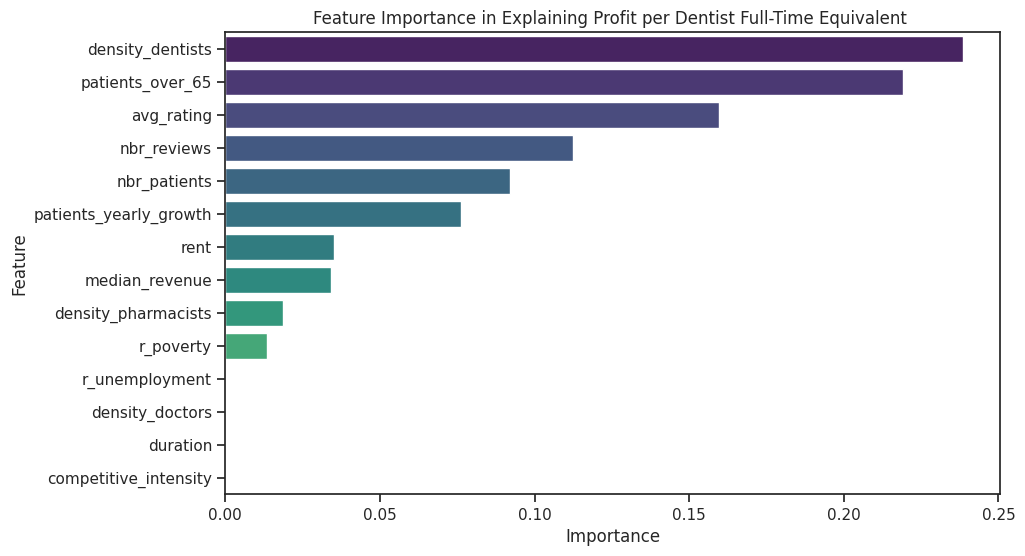

#### 



,Feature,Importance
11,density_dentists,0.238671
5,patients_over_65,0.219224
1,avg_rating,0.159811
0,nbr_reviews,0.112546
3,nbr_patients,0.092013
4,patients_yearly_growth,0.076243
2,rent,0.035062
6,median_revenue,0.034096
10,density_pharmacists,0.018694
8,r_poverty,0.013640


In [ ]:
tree61 = DecisionTreeRegressor()
model61 = AdaBoostRegressor(estimator=tree61)

param_grid61 = {
    'n_estimators': [2, 3, 4, 5],
    'estimator__max_depth': [2, 3, 4]
}

loo61 = LeaveOneOut()

grid_search61 = GridSearchCV(
    estimator=model61,
    param_grid=param_grid61,
    cv=loo61,
    scoring='neg_median_absolute_error',
    verbose=1
)

grid_search61.fit(X_train61, y_train61)

best_model61 = grid_search61.best_estimator_
best_params61 = grid_search61.best_params_
best_score61 = -grid_search61.best_score_

print("Best Parameters:", best_params61)
print(f"Best Median Absolute Error: {best_score61:.4f}")

y_pred61 = grid_search61.predict(X_test61)
r2_61 = r2_score(y_test61, y_pred61)
print(f"R² Score: {r2_61:.4f}")

############ Calculate feature importances ############

# We use these hyperparameters to train on the entire dataset to assess feature importance

best_model61.fit(X61, y61)

feature_importances61 = best_model61.feature_importances_

# Create a DataFrame to display feature importances
importance_df61 = pd.DataFrame({
    'Feature': X61.columns,
    'Importance': feature_importances61
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df61, palette="viridis")
plt.title('Feature Importance in Explaining Profit per Dentist Full-Time Equivalent ')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("####", '\n')
importance_df61

Once again, the model successfully predicted the target variable from the test set, achieving an R² score higher than 0.4, given the size of our dataset. However, it is surprising to note how much the behavior of our model has changed compared to that from Question 2, especially since we only added one feature. In fact, many features exhibit null importance for the model, particularly the competitive intensity feature. Even after testing several models, the results remain quite surprising. This is even more notable when we refer to the PDP analysis conducted in Question 2, which highlights the negative impact that competition can have on private dental clinics.
<br><br>

**That being said, we should consider the relevance of the dataset, given its limited size, along with the model employed in relation to the results**

#### Second strategy

In [ ]:
data_transform_q6_s2 = data_transform_q6.copy()

In [ ]:
# We create our target variable

X62 = data_transform_q6_s2.drop(['r_margin',], axis = 1)
y62 = data_transform_q6_s2['r_margin']

X_train62, X_test62, y_train62, y_test62 = train_test_split(X62, y62, test_size=0.1, random_state=42)

Fitting 63 folds for each of 12 candidates, totalling 756 fits
Best Parameters: {'estimator__max_depth': 4, 'n_estimators': 4}
Best Median Absolute Error: 0.0529
R² Score: 0.3120


<ipython-input-344-c9eaa3c4b59b>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df62, palette="viridis")


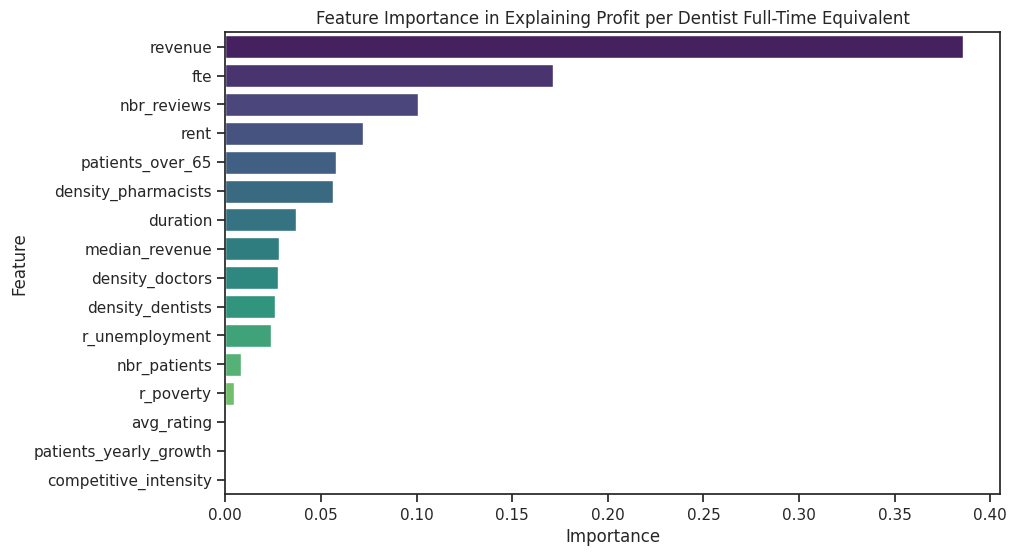

#### 



,Feature,Importance
0,revenue,0.385916
1,fte,0.171433
2,nbr_reviews,0.100605
4,rent,0.072114
7,patients_over_65,0.057780
12,density_pharmacists,0.056212
14,duration,0.036954
8,median_revenue,0.028148
11,density_doctors,0.027614
13,density_dentists,0.026108


In [ ]:
tree62 = DecisionTreeRegressor()
model62 = AdaBoostRegressor(estimator=tree61)

param_grid62 = {
    'n_estimators': [2, 3, 4, 5],
    'estimator__max_depth': [2, 3, 4]
}

loo62 = LeaveOneOut()

grid_search62 = GridSearchCV(
    estimator=model62,
    param_grid=param_grid62,
    cv=loo62,
    scoring='neg_median_absolute_error',
    verbose=1
)

grid_search62.fit(X_train62, y_train62)

best_model62 = grid_search62.best_estimator_
best_params62 = grid_search62.best_params_
best_score62 = -grid_search62.best_score_

print("Best Parameters:", best_params62)
print(f"Best Median Absolute Error: {best_score62:.4f}")

y_pred62 = grid_search62.predict(X_test62)
r2_62 = r2_score(y_test62, y_pred62)
print(f"R² Score: {r2_62:.4f}")

############ Calculate feature importances ############

# We use these hyperparameters to train on the entire dataset to assess feature importance

best_model62.fit(X62, y62)

feature_importances62 = best_model62.feature_importances_

# Create a DataFrame to display feature importances
importance_df62 = pd.DataFrame({
    'Feature': X62.columns,
    'Importance': feature_importances62
}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df62, palette="viridis")
plt.title('Feature Importance in Explaining rate margin')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

print("####", '\n')
importance_df62

Once again, competitive intensity does not significantly impact the center's performance, leading us to the same conclusion as with the question 2.

### Clustering when Competitiveness is Taken into Account

We perform the exact same procedure as in Question 3 to cluster the dental centers.

In [ ]:
data_transform_clustering_q6 = data_transform.copy()
data_transform_clustering_q6['competitive_intensity'] = gdf_centers['competitive_intensity']

scaler = StandardScaler()
data_transform_clustering_q6 = pd.DataFrame(scaler.fit_transform(data_transform_clustering_q6), columns=data_transform_clustering_q6.columns)

In [ ]:
best_score = -1
best_k = 0

for k in range(2, 9):

    clustering = SpectralClustering(n_clusters=k, affinity='nearest_neighbors', random_state=42)
    labels = clustering.fit_predict(data_transform_clustering_q6)


    score = silhouette_score(data_transform_clustering_q6, labels)
    print(f"Nombre de clusters: {k}, Score de silhouette: {score}")

    if score > best_score:
        best_score = score
        best_k = k

print(f"Meilleur nombre de clusters : {best_k} avec un score de silhouette de : {best_score}")

Nombre de clusters: 2, Score de silhouette: 0.30029179730972716
Nombre de clusters: 3, Score de silhouette: 0.1905007921909613
Nombre de clusters: 4, Score de silhouette: 0.17761341544981318
Nombre de clusters: 5, Score de silhouette: 0.17709489356844466
Nombre de clusters: 6, Score de silhouette: 0.15876297483901583
Nombre de clusters: 7, Score de silhouette: 0.12449069888679914
Nombre de clusters: 8, Score de silhouette: 0.12119289886318749
Meilleur nombre de clusters : 2 avec un score de silhouette de : 0.30029179730972716


In [ ]:
clustering = SpectralClustering(n_clusters=best_k, affinity='nearest_neighbors', random_state=42)
labels = clustering.fit_predict(data_transform_clustering_q6)

df2 = pd.DataFrame(data_transform_clustering_q6, columns=data_transform_clustering_q6.columns)
df2['Cluster'] = labels

In [ ]:
p_values = {}

for column in df2.columns[:-1]:
    groups = [group[column].values for name, group in df2.groupby('Cluster')]
    F_stat, p_value = stats.f_oneway(*groups)
    p_values[column] = p_value

p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [ ]:
p_values_df = pd.DataFrame(list(p_values.items()), columns=['Variable', 'p_value'])
p_values_df.sort_values(by='p_value', inplace=True)

In [ ]:
p_values_df

,Variable,p_value
13,density_pharmacists,2.069280e-28
14,density_dentists,9.481361e-25
5,rent,1.445513e-24
6,nbr_patients,2.788557e-21
12,density_doctors,1.440853e-18
9,median_revenue,1.554851e-09
10,r_unemployment,1.141261e-07
7,patients_yearly_growth,7.952838e-04
3,nbr_reviews,2.457138e-02
4,avg_rating,3.118831e-02


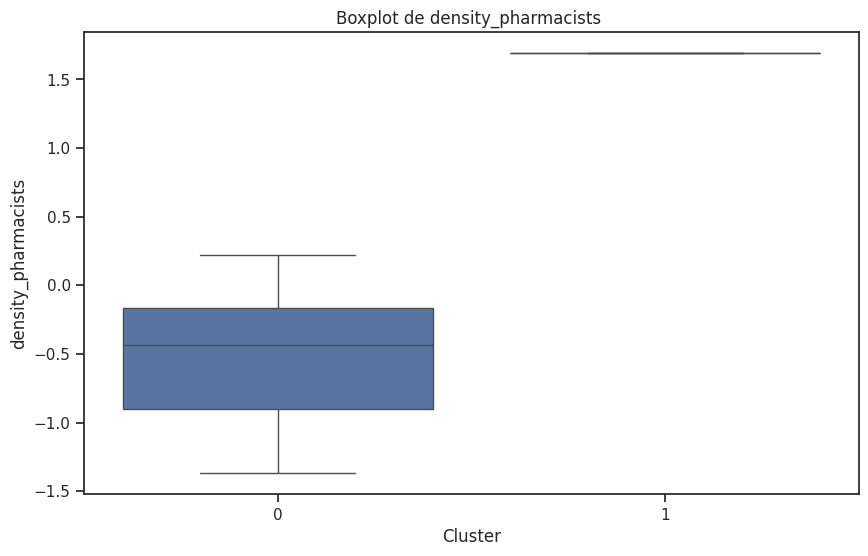

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y=most_discriminant_variable['Variable'], data=df2)
plt.title(f'Boxplot de {most_discriminant_variable["Variable"]} ')
plt.show()

In conclusion, the number of patients in the area is still the most critical variable, even when accounting for the presence of competing practices. The data can still be divided into two different clusters, depending on the density of the catchment area.

## Question 7

**Summarize your findings** in business terms and formulate a recommendation on how to improve the overall dental center network performance based on the answers to the previous questions.

**Note: for this question no code is expected**

We can sumarized our finding in **few key points :**


1.     **Patient Demographics Drive Revenue**: The number of patients, particularly those over 65, is the most critical factor influencing revenue. This demographic, often having higher healthcare needs and financial resources, tends to visit dental centers more frequently, making them a key segment.

2.     For both our strategies, the role of catchment features is significant; the number of patients in the catchment area plays a key role in performance, and dentist density is also important due to competition.

3.     Nevertheless, our private dental clinic should prioritize operational features over catchment area features. While catchment features do significantly impact performance, there is an equal balance of both types among the top eight features in terms of importance, as noted in question 2. Notably, the **clinic's rating** plays a crucial role, encouraging more people to seek treatment from the clinic's dentists. Additionally, the clinic should not expect to achieve strong performance immediately, but rather see in the **long term**, as we have seen that the length of time the clinic has been established plays a significant role.


**Strategy :** <br><br>



The private clinic could adopt a more **"aggressive"** approach to **optimize profit per dentist**, **focusing intensively on a few key factors** like **city selection**, **average rating and number of reviews**, and **targeting older demographics**. This narrow, targeted focus would allow the clinic to maximize profitability per dentist by strategically selecting high-impact areas and appealing directly to valuable patient segments. In contrast, when **optimizing for overall margin**, the clinic might take a **broader approach**, balancing these factors with operational efficiencies and cost controls.

<br>

To boost performance—regardless of the objective—the clinic should focus on attracting high-value patients, **particularly those over 65**, by offering tailored services and maintaining high satisfaction to encourage retention and referrals. Choosing the **right location** is essential; even with higher rent, the clinic should prioritize **dynamic**, **densely populated** **cities** rather than solely affluent areas. Marketing should highlight the clinic’s **strong rating** and target local areas with high patient potential. Prioritizing operational efficiency, patient throughput, and an optimal dentist-to-patient ratio, along with cost control and high-value service offerings, will improve margins. With a **long-term approach**, the clinic can establish a loyal patient base and achieve steady, sustainable growth over rapid expansion.
